In [1]:
import os
import sys
import torch
from transformers import (
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    set_seed,
)
from datasets import load_from_disk
from miditok import REMI

# Configuration
DATASET_ROOT = "processed_datasets"
TOKENIZER_DIR = os.path.join(DATASET_ROOT, "maestro_tok")
MODEL_OUTPUT_ROOT = "trained_models"
TARGET_STYLES = ["Baroque", "Romantic"]

CONFIG = {
    "base_model": "Natooz/Maestro-REMI-bpe20k",
    "batch_size": 2,
    "grad_accum": 8,
    "num_epochs": 5,
    "learning_rate": 5e-5,
    "save_steps": 500,
    "save_total_limit": 2,
    "logging_steps": 50,
    "seed": 42,
}
set_seed(CONFIG["seed"])

# Helper class for data collator
class MidiTokenizerWrapper:
    def __init__(self, midi_tok):
        self.pad_token_id = getattr(midi_tok, "pad_token_id", 0) or 0
    
    def pad(self, encoded_inputs, padding=True, max_length=None, return_tensors="pt", **kwargs):
        ids = [ex["input_ids"] for ex in encoded_inputs]
        tensor = torch.tensor(ids, dtype=torch.long)
        labels = tensor.clone()
        labels[labels == self.pad_token_id] = -100
        attn = (tensor != self.pad_token_id).long()
        return {"input_ids": tensor, "labels": labels, "attention_mask": attn}

def load_tokenizer():
    if not os.path.isdir(TOKENIZER_DIR):
        raise FileNotFoundError(f"Directory not found: {TOKENIZER_DIR}")
    
    print(f"Loading tokenizer from: {TOKENIZER_DIR}")
    tok = REMI.from_pretrained(TOKENIZER_DIR)
    if tok.pad_token_id is None:
        tok.pad_token_id = 0
    print(f"Tokenizer loaded. Vocab size: {len(tok)}")
    return tok

def get_model(vocab_size):
    print(f"Loading base model: {CONFIG['base_model']}")
    try:
        model = GPT2LMHeadModel.from_pretrained(
            CONFIG["base_model"], ignore_mismatched_sizes=True
        )
    except Exception as e:
        print(f"Base model load failed, falling back to gpt2. Error: {e}")
        model = GPT2LMHeadModel.from_pretrained("gpt2")
    
    model.resize_token_embeddings(vocab_size)
    return model

def train_one_style(style, tokenizer):
    print(f"\nTraining style: {style}")
    dset_path = os.path.join(DATASET_ROOT, f"{style}_train")
    
    if not os.path.exists(dset_path):
        print(f"Dataset not found: {dset_path}")
        return
    
    ds = load_from_disk(dset_path)
    print(f"Training samples: {len(ds)}")

    model = get_model(len(tokenizer))

    args = TrainingArguments(
        output_dir=os.path.join(MODEL_OUTPUT_ROOT, f"{style}_gpt2"),
        overwrite_output_dir=True,
        num_train_epochs=CONFIG["num_epochs"],
        per_device_train_batch_size=CONFIG["batch_size"],
        gradient_accumulation_steps=CONFIG["grad_accum"],
        learning_rate=CONFIG["learning_rate"],
        weight_decay=0.01,
        save_steps=CONFIG["save_steps"],
        save_total_limit=CONFIG["save_total_limit"],
        logging_steps=CONFIG["logging_steps"],
        prediction_loss_only=True,
        fp16=torch.cuda.is_available(),
        dataloader_num_workers=2,
        report_to="none",
        seed=CONFIG["seed"],
    )

    collator = DataCollatorForLanguageModeling(
        tokenizer=MidiTokenizerWrapper(tokenizer), mlm=False
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds,
        data_collator=collator,
        tokenizer=tokenizer,
    )

    trainer.train()

    final_dir = os.path.join(MODEL_OUTPUT_ROOT, f"final_{style}_gpt2")
    trainer.save_model(final_dir)
    tokenizer.save_pretrained(final_dir)
    print(f"Model saved to: {final_dir}")

if __name__ == "__main__":
    if torch.cuda.is_available():
        print(f"GPU detected: {torch.cuda.get_device_name(0)}")
    else:
        print("No GPU detected. Training on CPU.")

    try:
        tokenizer = load_tokenizer()
    except Exception as err:
        print(f"Tokenizer load error: {err}")
        sys.exit(1)

    os.makedirs(MODEL_OUTPUT_ROOT, exist_ok=True)

    for style in TARGET_STYLES:
        train_one_style(style, tokenizer)

    print("\nTraining complete.")

/home/dengjian/.conda/envs/507_gpu_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU detected: Tesla V100-PCIE-16GB
Loading tokenizer from: processed_datasets/maestro_tok
Tokenizer loaded. Vocab size: 20000

Training style: Baroque
Training samples: 11749
Loading base model: Natooz/Maestro-REMI-bpe20k


/home/dengjian/.conda/envs/507_gpu_env/lib/python3.10/site-packages/miditok/classes.py:886: UserWarning: Argument nb_tempos has been renamed num_tempos, you should consider to updateyour code with this new argument name.
  return cls(**input_dict, **kwargs)
/tmp/ipykernel_1830792/1663736751.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
50,2.810400
100,2.141500
150,1.989400
200,1.885600
250,1.817100
300,1.768900
350,1.692500
400,1.666100
450,1.586400
500,1.650400


Model saved to: trained_models/final_Baroque_gpt2

Training style: Romantic
Training samples: 12927
Loading base model: Natooz/Maestro-REMI-bpe20k


/tmp/ipykernel_1830792/1663736751.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss
50,2.986400
100,2.298400
150,2.101500
200,1.995900
250,1.926700
300,1.857600
350,1.807500
400,1.813000
450,1.720900
500,1.730600


Model saved to: trained_models/final_Romantic_gpt2

Training complete.


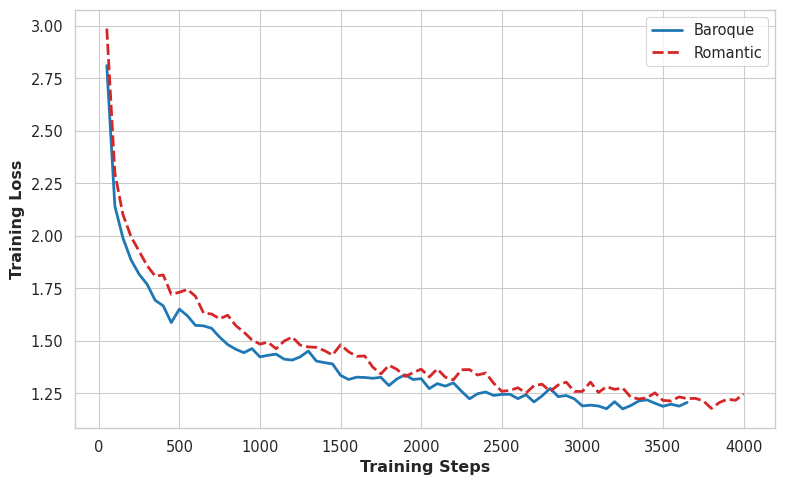

Chart saved as fig2_loss_convergence.png


In [2]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Configuration
json_paths = {
    "Baroque": "/home/dengjian/trained_models/Baroque_gpt2/checkpoint-3675/trainer_state.json",
    "Romantic": "/home/dengjian/trained_models/Romantic_gpt2/checkpoint-4040/trainer_state.json"
}

all_data = []

# Load data
for style, path in json_paths.items():
    if os.path.exists(path):
        try:
            with open(path, 'r') as f:
                data = json.load(f)
                history = [x for x in data["log_history"] if "loss" in x]
                
                for entry in history:
                    all_data.append({
                        "Step": entry["step"],
                        "Loss": entry["loss"],
                        "Style": style
                    })
        except Exception as e:
            print(f"Error loading {style}: {e}")
    else:
        print(f"File not found: {path}")

df = pd.DataFrame(all_data)

# Plotting
if not df.empty:
    # Set academic style
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
    
    plt.figure(figsize=(8, 5))
    
    sns.lineplot(
        data=df, 
        x="Step", 
        y="Loss", 
        hue="Style",
        style="Style",               # <--- Added: Makes lines solid/dashed
        markers=False,               # Keep lines smooth
        dashes=True,                 # Enable dashes
        palette=["#1f77b4", "#d62728"],
        linewidth=2
    )

    plt.xlabel("Training Steps", fontweight='bold')
    plt.ylabel("Training Loss", fontweight='bold')
    
    # Legend without title, simple frame
    plt.legend(title=None, frameon=True)
    
    plt.tight_layout()
    plt.savefig("fig2_loss_convergence.png", dpi=300)
    plt.show()
    
    print("Chart saved as fig2_loss_convergence.png")
else:
    print("No valid data found to plot.")